# **CSST106 - Perception and Computer Vision**
##**MIDTERM EXAM PROJECT**
###**Lesly-Ann B. Victoria and Jonathan Q. Laganzon from BSCS-4B**

#### **IMPORTING LIBRARIES**

In [ ]:
import numpy as np
import cv2
import joblib
import glob
import os
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imutils.object_detection import non_max_suppression
from skimage import color
from skimage.transform import pyramid_gaussian
import matplotlib.pyplot as plt

#### **DATA PREPARATION**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define a sliding window function
def sliding_window(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])

# Prepare training data
train_data = []
train_labels = []
pos_im_path = '/content/drive/MyDrive/HOG_SVM/DATAIMAGE/positive/'  # Path to positive images
neg_im_path = '/content/drive/MyDrive/HOG_SVM/DATAIMAGE/negative/'  # Path to negative images
model_path = '/content/drive/MyDrive/HOG_SVM/models/models.dat'     # Path to save the trained model

# Load positive samples
for filename in glob.glob(os.path.join(pos_im_path, "*.png")):
    img = cv2.imread(filename, 0)
    img = cv2.resize(img, (64, 128))
    fd = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), visualize=False)
    train_data.append(fd)
    train_labels.append(1)

# Load negative samples
for filename in glob.glob(os.path.join(neg_im_path, "*.jpg")):
    img = cv2.imread(filename, 0)
    img = cv2.resize(img, (64, 128))
    fd = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), visualize=False)
    train_data.append(fd)
    train_labels.append(0)

train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(f"Data Prepared - Positive samples: {sum(train_labels)}, Negative samples: {len(train_labels) - sum(train_labels)}")



Data Prepared - Positive samples: 2416, Negative samples: 3234


#### **MODEL TRAINING**

In [ ]:
# Train SVM classifier
model = LinearSVC()
print("Training Support Vector Machine...")
model.fit(train_data, train_labels)
joblib.dump(model, model_path)
print(f"Model saved at: {model_path}")

# Define detection function
def detect_objects(image, model, window_size=(64, 128), step_size=(9, 9), downscale=1.25, confidence_threshold=0.5):
    detections = []
    scale = 0
    for im_scaled in pyramid_gaussian(image, downscale=downscale):
        if im_scaled.shape[0] < window_size[1] or im_scaled.shape[1] < window_size[0]:
            break
        for (x, y, window) in sliding_window(im_scaled, window_size, step_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue
            window = color.rgb2gray(window)
            fd = hog(window, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), visualize=False)
            fd = fd.reshape(1, -1)
            pred = model.predict(fd)
            if pred == 1 and model.decision_function(fd) > confidence_threshold:
                detections.append((int(x * (downscale ** scale)), int(y * (downscale ** scale)),
                                   model.decision_function(fd), int(window_size[0] * (downscale ** scale)),
                                   int(window_size[1] * (downscale ** scale))))
        scale += 1
    return detections

Training Support Vector Machine...
Model saved at: /content/drive/MyDrive/HOG_SVM/models/models.dat


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### **MODEL TESTING AND EVALUATION**

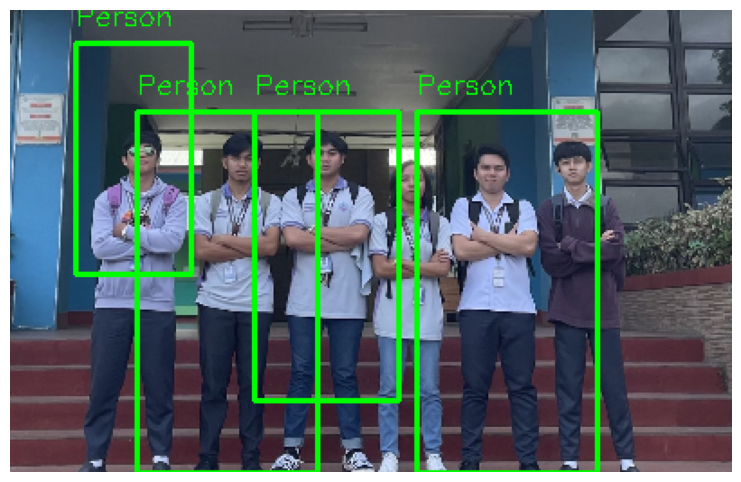

Metrics for /content/drive/MyDrive/HOG_SVM/test/avatar.jpg:
Detection Speed: 5.3941 seconds
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
Result image saved to: /content/drive/MyDrive/HOG_SVM/results/avatar.jpg


In [ ]:
# Ensure the results folder exists
results_folder = '/content/drive/MyDrive/HOG_SVM/results'
os.makedirs(results_folder, exist_ok=True)

def evaluate_model(image_path, model, confidence_threshold=0.5):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (400, 256))

    start_time = time.time()
    detections = detect_objects(image, model)
    detection_time = time.time() - start_time

    # Non-max suppression
    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
    scores = [score[0] for (x, y, score, w, h) in detections]
    pick = non_max_suppression(rects, probs=np.array(scores), overlapThresh=0.3)

    # Adjust y_true and y_pred lengths to match detections
    y_true = [1] * len(pick)  # Assume all picked detections are true positives initially
    y_pred = [1 if score > confidence_threshold else 0 for score in scores[:len(pick)]]

    # Draw bounding boxes on the image
    for (x1, y1, x2, y2) in pick:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, 'Person', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Save the image with detections to the results folder
    result_image_path = os.path.join(results_folder, os.path.basename(image_path))
    cv2.imwrite(result_image_path, image)

    # Display the image using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    print(f"Metrics for {image_path}:")
    print(f"Detection Speed: {detection_time:.4f} seconds")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"Result image saved to: {result_image_path}")

# Test the model with a sample image
evaluate_model('/content/drive/MyDrive/HOG_SVM/test/avatar.jpg', model)